In [1]:
from src.utils.general_functions import get_subfolders_at_depth, load_dict_from_binary
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
from omegaconf import OmegaConf
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from src.utils.math import calculate_avg_std_from_dictionaries
from src.plot.general import plot_scalar_dictionary
from src.utils.fmm import get_parameters_names_list
from src.datasets.datasetsLibrary import get_ptb_xl_fmm_dataset, get_shaoxing_fmm_dataset, get_ecg5000_dataset
from src.utils.general_functions import format_number_with_sign
from src.plot.general import plot_group_bars
current_path = "/mnt/giacomo/sfl"#os.getcwd()
results_path = os.path.join(current_path,"results")

# Plot settings
labelssize = 14
ticksize = 12
legendsize = 12
colors = ["#fec44f", "#d95f0e", "#fff7bc"]#["#66c2a5", "#fc8d62", "#8da0cb"]

# FMM settings 
num_features = 1
num_waves = 5
def get_conf_from_paths(paths):
    conf_list = []
    for p in paths:
        file_path = os.path.join(p,"conf.yaml")
        # with open(file_path,"r") as fp:
        cfg = OmegaConf.load(file_path)
        cfg["path"] = p
        conf_list.append(cfg)
    return conf_list

def get_completed_paths(config_files, log=True):
    completed_config_files = []
    not_completed_experiments = 0
    completed_experiments = 0
    for cfg in config_files:
        if(cfg["completed"]==True):
            completed_config_files.append(cfg)
            completed_experiments += 1
        else:
            not_completed_experiments += 1
    # if(not_completed_experiments>0):
    # print(f"Completed experiments: {completed_experiments} \nNot completed experiments: {not_completed_experiments}")
    total_experiments = completed_experiments + not_completed_experiments
    if(log):
        print(f"Completed experiments: {completed_experiments}/{total_experiments}")
    return completed_config_files

def load_binary_dict_from_paths(paths, file_name):
    # Load dicts from paths
    dict_list = []
    for path in paths:
        full_file_name = os.path.join(path,file_name)
        mydict = load_dict_from_binary(full_file_name)
        dict_list.append(mydict)
    return dict_list

def load_numpy_from_paths(paths,file_name):
    # Load numpy file from paths
    np_list = []
    for path in paths:
        full_file_name = os.path.join(path,file_name)
        np_item = np.load(full_file_name)
        np_list.append(np_item)
    return np_list
    
def load_json_from_exp(paths, file_name):
    # Load json file from paths
    roc_list = []
    for path in paths:
        full_file_name = os.path.join(path,file_name)
        roc_dict = json.load(open(full_file_name,"r")) 
        roc_list.append(roc_dict)
    return roc_list

def extract_key_from_histories(history_list, max_len=1000, key="loss"):
    num_items = len(history_list)
    history_matrix = np.NaN * np.ones((num_items,max_len))
    for i,h_dict in enumerate(history_list):
        h = h_dict[key]
        len_h = len(h)
        history_matrix[i,:len_h] = h
    return history_matrix

def extract_auroc_from_roc_list(roc_list):
    num_items = len(roc_list)
    auroc_vector = np.zeros((num_items))
    for i,roc_dict in enumerate(roc_list):
        auroc_vector[i] = roc_dict["roc_auc"]
    return auroc_vector

def save_png_eps_figure(filename):
    full_filename = os.path.join(current_path,"images",filename)
    for extension in [".png",".eps"]:
        plt.savefig(full_filename+extension,bbox_inches='tight')


# exp_paths = get_all_experiments_paths(base_path=results_path,model="ecgnet",dataset="shaoxing_fmm",
#                           split=True, optimizer="Adam", learning_rate=0.0005)
# conf_files = get_conf_from_paths(exp_paths)
# completed_config_files = get_completed_paths(config_files=conf_files)
# completed_paths = [cfg["path"] for cfg in completed_config_files]
# completed_histories = load_histories(completed_paths,file_name="history.json")
# completed_rocs = load_json_from_exp(completed_paths,file_name="test_roc.json")
# # completed_corrs = load_json_from_exp(completed_paths, file_name="correlation_normal_sorted")
# history_matrix = extract_key_from_histories(completed_histories,key="val_loss")
# roc_vector = extract_auroc_from_roc_list(completed_rocs)
# avg_hist = np.nanmean(history_matrix,axis=0)
# std_hist = np.nanstd(history_matrix,axis=0)
# x_axis = np.arange(avg_hist.shape[0])
# plt.plot(x_axis,avg_hist)
# plt.fill_between(x_axis,avg_hist-std_hist, avg_hist+std_hist, alpha=0.5,)

2023-12-05 19:34:08.294156: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-05 19:34:08.332179: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Define model names
model_names = ["ecgnet", "fmm_ecgnet",  "encdec_ad", "fmm_encdec_ad",
                "bert_ecg", "fmm_bert_ecg", "dense_ae", "fmm_dense_ae", "cvae", "fmm_cae", "ecg_adgan", "diffusion_ae"]
# Define dataset names
dataset_names = ["shaoxing_fmm", "ptb_xl_fmm","ecg5000"]
# Define all learning rates
learning_rate_values = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5] #,5e-6] #1e-6
learning_rate_values_str = ["{:.0e}".format(lr) for lr in learning_rate_values]
# Define all the fmm models names
not_fmm_model_names = ["bert_ecg", "cvae", "encdec_ad", "ecgnet", "dense_ae"]
fmm_model_names = ["fmm_bert_ecg","fmm_cae", "fmm_encdec_ad", "fmm_ecgnet", "fmm_dense_ae"]
gan_names = ["ecg_adgan"]
diffusion_names = ["diffusion_ae"]
# Dictionary to convert model name to optimizer
md_name_to_opt_dict = {}
md_name_to_opt_dict.update((key, 'Adam') for key in model_names)
md_name_to_opt_dict.update((key, 'legacy_adam') for key in gan_names)
md_name_to_opt_dict.update((key, 'adam_torch') for key in diffusion_names)
# For each dataset, get and plot validation accuracies of all the models
history_key_dict = {}
history_key_dict.update((key, 'val_loss') for key in model_names)
history_key_dict.update((key, 'D_loss') for key in gan_names)
history_key_dict.update((key, 'sum_loss_train') for key in diffusion_names)
key_to_metric = {"val_loss":"Validation Loss", "D_loss": "Discriminator Loss", "sum_loss_train": "Loss"}
max_len = 20000
def get_all_experiments_paths(base_path, model, dataset, split, optimizer, learning_rate, depth=1):
    # Function to get all the result paths for a given model, dataset, split, optimizer, learning rate
    lr = str(learning_rate)
    folder_path = os.path.join(base_path,f"{model}_{dataset}",f"split_{split}_opt_{optimizer}_lr_{lr}")
    return get_subfolders_at_depth(folder_path=folder_path,depth=depth)
history_dict_list = []
for ds_name in dataset_names:
    ds_history_dict = {}
    for md_name in model_names:
        history_key = history_key_dict[md_name]
        metric_name = key_to_metric[history_key]
        md_history_dict = {}
        for lr in learning_rate_values:
            # print(f"Dataset: {ds_name} Model: {md_name} lr: {lr}")
            lr_dict = {}
            exp_paths = get_all_experiments_paths(base_path=results_path,
                                                  model=md_name,
                                                  dataset=ds_name,
                                                  learning_rate=lr,
                                                  split=True, 
                                                  optimizer=md_name_to_opt_dict[md_name],)
            conf_files = get_conf_from_paths(exp_paths)
            completed_config_files = get_completed_paths(config_files=conf_files,log=False)
            if(len(completed_config_files)==5):
                completed_paths = [cfg["path"] for cfg in completed_config_files]
                completed_histories = load_binary_dict_from_paths(completed_paths, "history.json")
                completed_rocs = load_json_from_exp(completed_paths,file_name="test_roc.json")
                history_matrix = extract_key_from_histories(completed_histories,key=history_key, max_len=max_len)
                roc_vector = extract_auroc_from_roc_list(completed_rocs)
                lr_dict[history_key] = history_matrix 
                lr_dict["auroc"] = roc_vector 
                num_experiments = len(completed_paths)
                assert roc_vector.shape[0]==num_experiments
                dict_to_add = {"Dataset": ds_name, "Model": md_name, "Learning Rate":lr,
                                            "Auroc": np.mean(roc_vector), 
                                            "Auroc Std": np.std(roc_vector),
                                            metric_name: np.nanmean(history_matrix,axis=0),
                                            f"{metric_name} Std": np.nanstd(history_matrix,axis=0),
                                            "Num Exp": num_experiments}
                if(md_name in fmm_model_names and ds_name!="ecg5000"):
                    completed_corrs = load_json_from_exp(completed_paths, file_name="correlation_normal_sorted")
                    assert len(completed_corrs)==num_experiments
                    avg_corrs, std_corrs = calculate_avg_std_from_dictionaries(completed_corrs)
                    lr_dict["correlation_sorted"] = completed_corrs 
                    dict_to_add["Correlation"] = avg_corrs
                    dict_to_add["Correlation Std"] = std_corrs
                history_dict_list.append(dict_to_add)

/tmp/ipykernel_4149171/972848822.py:62: RuntimeWarning: Mean of empty slice
  metric_name: np.nanmean(history_matrix,axis=0),
/home/giacomo/installers/anaconda3/envs/sfl31/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


shaoxing_fmm fmm_ecgnet 1e-05
shaoxing_fmm fmm_encdec_ad 0.0001
shaoxing_fmm fmm_bert_ecg 0.0001
shaoxing_fmm fmm_dense_ae 0.0001
shaoxing_fmm fmm_cae 0.0001
ptb_xl_fmm fmm_ecgnet 0.0001
ptb_xl_fmm fmm_encdec_ad 0.0001
ptb_xl_fmm fmm_bert_ecg 0.0001
ptb_xl_fmm fmm_dense_ae 0.0001
ptb_xl_fmm fmm_cae 0.0001
ecg5000 fmm_ecgnet 0.0001
ecg5000 fmm_encdec_ad 0.0001
ecg5000 fmm_bert_ecg 0.0001
ecg5000 fmm_dense_ae 0.0001
ecg5000 fmm_cae 0.0001


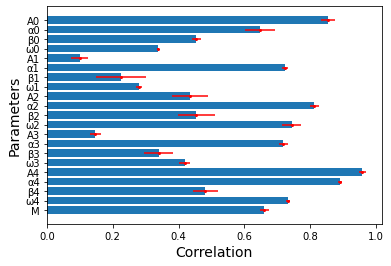

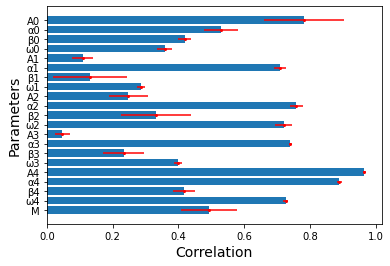

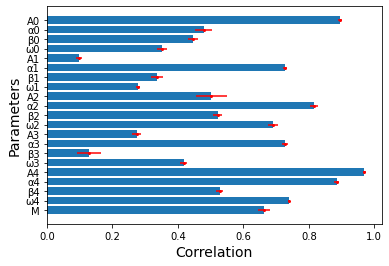

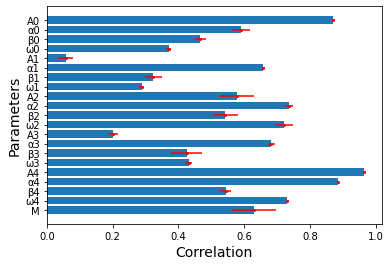

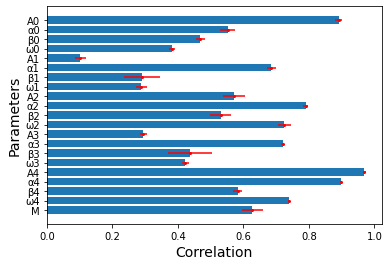

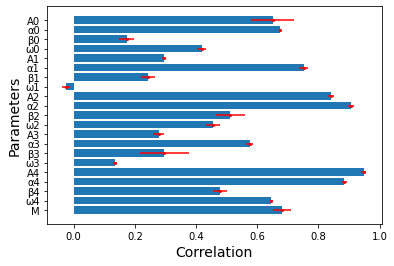

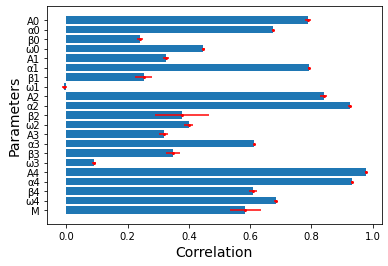

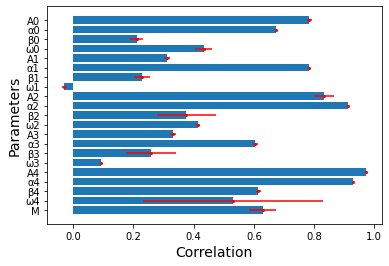

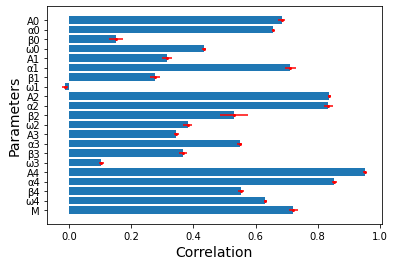

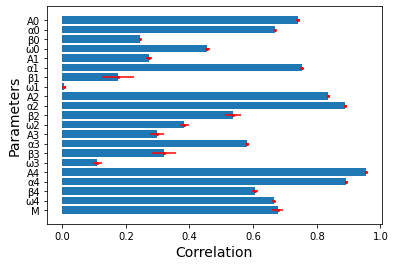

In [3]:
# Plot correlation of models on different datasets
df = pd.DataFrame(history_dict_list)
learning_rate_to_plot = 0.0001 # "best" or a specific learning rate
for dataset in df["Dataset"].unique():
    for model in df["Model"].unique():
        if(model in fmm_model_names):
            print(f"{dataset} {model} {lr}")
            selected_rows = df[(df['Dataset'] == dataset) & (df['Model'] == model) ] #& (df['Learning Rate'] == "dense_ae")
            if(selected_rows.shape[0]>0):
                if(learning_rate_to_plot=="best"):
                    max_value_index = selected_rows['Auroc'].idxmax()
                    row_to_plot = selected_rows.loc[max_value_index]
                else:
                    row_to_plot = selected_rows[(selected_rows['Learning Rate'] == learning_rate_to_plot) ]
                    row_to_plot = row_to_plot.iloc[0]
                if(model in fmm_model_names and dataset!="ecg5000"):
                    lr = row_to_plot["Learning Rate"]
                    avg_dict = row_to_plot["Correlation"]
                    std_dict = row_to_plot["Correlation Std"]
                    plot_scalar_dictionary(data=avg_dict,std=std_dict,title="",fontsize=14)
                    save_png_eps_figure(f"correlation_ds_{dataset}_md_{model}_lr_{lr}")
        # std_metric = row_to_plot[f"{metric_name} Std"]
        # lr = row_to_plot["Learning Rate"]
        # x_axis = np.arange(avg_metric.shape[0])
        # plt.plot(x_axis,avg_metric, label="{0} lr: {1:.0e}".format(model,lr))
        # plt.fill_between(x_axis,avg_metric-std_metric, avg_metric+std_metric, alpha=0.5,)
    

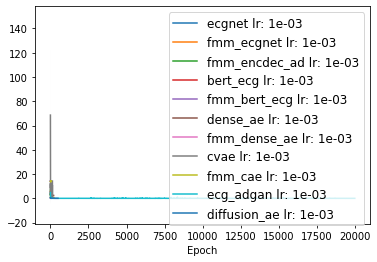

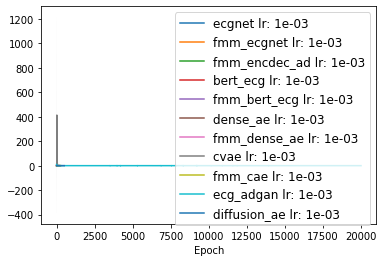

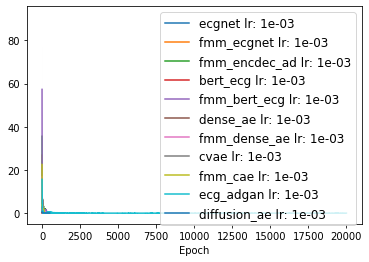

In [4]:
# Plot selected metric (e.g., validation loss) of models on different datasets
df = pd.DataFrame(history_dict_list)
learning_rate_to_plot = 0.001 # "best" or a specific learning rate
#Models to plot (exclude encdec_ad)
models_to_plot = df["Model"].unique()
models_to_plot = models_to_plot[models_to_plot!="encdec_ad"]
for ds_name in df["Dataset"].unique():
    plt.figure()
    for md_name in models_to_plot:
        metric_name = key_to_metric[history_key_dict[md_name]]
        selected_rows = df[(df['Dataset'] == ds_name) & (df['Model'] == md_name) ] #& (df['Learning Rate'] == "dense_ae")
        if(selected_rows.shape[0]>0):
            if(learning_rate_to_plot=="best"):
                max_value_index = selected_rows['Auroc'].idxmax()
                row_to_plot = selected_rows.loc[max_value_index]
            else:
                row_to_plot = selected_rows[(selected_rows['Learning Rate'] == learning_rate_to_plot) ]
                row_to_plot = row_to_plot.iloc[0]
            avg_metric = row_to_plot[metric_name]
            std_metric = row_to_plot[f"{metric_name} Std"]
            lr = row_to_plot["Learning Rate"]
            x_axis = np.arange(avg_metric.shape[0])
            plt.plot(x_axis,avg_metric, label="{0} lr: {1:.0e}".format(md_name,lr))
            plt.fill_between(x_axis,avg_metric-std_metric, avg_metric+std_metric, alpha=0.5,)
    plt.legend(fontsize=legendsize)
    plt.xlabel("Epoch")

In [5]:
# Create a DataFrame
df = pd.DataFrame(history_dict_list)
df["AUROC"] = df.apply(lambda row: "{0:.3f} ± {1:.3f}".format(round(row["Auroc"],3),round(row["Auroc Std"],3)), axis=1)
# df["Learning Rate"] = df["Learning Rate"].apply(lambda x: "{:.0e}".format(x))  #.apply(lambda x: round(np.log10(x),1))
# Iterate through unique datasets and create tables
auroc_table_list = []

for ds_name in df["Dataset"].unique():
    dataset_df = df[df["Dataset"] == ds_name]
    pivot_table = dataset_df.pivot(index="Model", columns="Learning Rate", values=["AUROC"])
    pivot_table = pivot_table.sort_index(axis=1, level=1)
    # Reindex the pivot table to match the desired order of rows and columns
    pivot_table = pivot_table.reindex(model_names)
    # pivot_table = pivot_table.reindex(learning_rate_values_str,axis=1)
    # pivot_table = pivot_table.style.format({"Learning Rate": "{:.1e}"}) 
    # print(f"Table for {dataset}:")
    # print(pivot_table.head())
    # print("\n")
    auroc_table_list.append({"dataset":ds_name, "table":pivot_table})
    

In [6]:
print(auroc_table_list[0]["dataset"])
auroc_table_list[0]["table"]

shaoxing_fmm


AUROC                                               \
Learning Rate        0.00001        0.00005        0.00010        0.00050   
Model                                                                       
ecgnet         0.575 ± 0.007  0.574 ± 0.006  0.568 ± 0.012  0.557 ± 0.011   
fmm_ecgnet     0.660 ± 0.008  0.659 ± 0.008  0.651 ± 0.006  0.641 ± 0.006   
encdec_ad      0.461 ± 0.003  0.461 ± 0.003  0.460 ± 0.003  0.460 ± 0.003   
fmm_encdec_ad  0.618 ± 0.004  0.609 ± 0.008  0.613 ± 0.006  0.603 ± 0.011   
bert_ecg       0.535 ± 0.008  0.512 ± 0.021  0.510 ± 0.041  0.546 ± 0.016   
fmm_bert_ecg   0.644 ± 0.004  0.645 ± 0.005  0.651 ± 0.004  0.612 ± 0.040   
dense_ae       0.636 ± 0.004  0.651 ± 0.005  0.653 ± 0.004  0.650 ± 0.004   
fmm_dense_ae   0.669 ± 0.006  0.678 ± 0.007  0.684 ± 0.008  0.699 ± 0.006   
cvae           0.698 ± 0.004  0.718 ± 0.007  0.730 ± 0.010  0.749 ± 0.022   
fmm_cae        0.713 ± 0.007  0.729 ± 0.006  0.727 ± 0.006  0.679 ± 0.057   
ecg_adgan      0.558 ± 0.037  0.576 ± 0.043  0.587 ± 0.020  0.543 ± 0.032   
diffusion_ae   0.491 ± 0.034  0.464 ± 0.008  0.464 ± 0.007  0.455 ± 0.011   

                              
Learning Rate        0.00100  
Model                         
ecgnet         0.566 ± 0.013  
fmm_ecgnet     0.642 ± 0.004  
encdec_ad      0.462 ± 0.006  
fmm_encdec_ad  0.607 ± 0.014  
bert_ecg       0.538 ± 0.050  
fmm_bert_ecg   0.560 ± 0.002  
dense_ae       0.637 ± 0.003  
fmm_dense_ae   0.692 ± 0.003  
cvae           0.737 ± 0.013  
fmm_cae        0.563 ± 0.004  
ecg_adgan      0.513 ± 0.007  
diffusion_ae   0.448 ± 0.006

In [7]:
print(auroc_table_list[1]["dataset"])
auroc_table_list[1]["table"]

ptb_xl_fmm


AUROC                                               \
Learning Rate        0.00001        0.00005        0.00010        0.00050   
Model                                                                       
ecgnet         0.662 ± 0.011  0.599 ± 0.055  0.578 ± 0.049  0.541 ± 0.054   
fmm_ecgnet     0.701 ± 0.007  0.732 ± 0.005  0.731 ± 0.003  0.718 ± 0.004   
encdec_ad      0.381 ± 0.000  0.384 ± 0.006  0.381 ± 0.000  0.382 ± 0.002   
fmm_encdec_ad  0.695 ± 0.008  0.689 ± 0.003  0.677 ± 0.003  0.653 ± 0.002   
bert_ecg       0.520 ± 0.032  0.489 ± 0.061  0.471 ± 0.031  0.499 ± 0.052   
fmm_bert_ecg   0.697 ± 0.005  0.694 ± 0.003  0.673 ± 0.021  0.673 ± 0.005   
dense_ae       0.673 ± 0.006  0.683 ± 0.004  0.685 ± 0.003  0.691 ± 0.003   
fmm_dense_ae   0.660 ± 0.001  0.671 ± 0.003  0.683 ± 0.003  0.698 ± 0.002   
cvae           0.694 ± 0.003  0.683 ± 0.005  0.684 ± 0.006  0.667 ± 0.003   
fmm_cae        0.710 ± 0.007  0.722 ± 0.003  0.718 ± 0.004  0.727 ± 0.007   
ecg_adgan      0.636 ± 0.076  0.662 ± 0.025  0.627 ± 0.036  0.585 ± 0.030   
diffusion_ae   0.464 ± 0.011  0.450 ± 0.014  0.453 ± 0.017  0.435 ± 0.018   

                              
Learning Rate        0.00100  
Model                         
ecgnet         0.575 ± 0.034  
fmm_ecgnet     0.712 ± 0.005  
encdec_ad      0.382 ± 0.002  
fmm_encdec_ad  0.643 ± 0.007  
bert_ecg       0.537 ± 0.030  
fmm_bert_ecg   0.676 ± 0.013  
dense_ae       0.692 ± 0.003  
fmm_dense_ae   0.699 ± 0.009  
cvae           0.663 ± 0.014  
fmm_cae        0.649 ± 0.076  
ecg_adgan      0.547 ± 0.054  
diffusion_ae   0.397 ± 0.012

In [8]:
print(auroc_table_list[2]["dataset"])
auroc_table_list[2]["table"]

ecg5000


AUROC                                               \
Learning Rate        0.00001        0.00005        0.00010        0.00050   
Model                                                                       
ecgnet         0.983 ± 0.002  0.993 ± 0.001  0.994 ± 0.001  0.992 ± 0.001   
fmm_ecgnet     0.977 ± 0.012  0.983 ± 0.006  0.988 ± 0.005  0.987 ± 0.003   
encdec_ad      0.927 ± 0.000  0.964 ± 0.032  0.982 ± 0.006  0.982 ± 0.001   
fmm_encdec_ad  0.960 ± 0.008  0.976 ± 0.006  0.965 ± 0.032  0.988 ± 0.003   
bert_ecg       0.963 ± 0.006  0.949 ± 0.020  0.962 ± 0.011  0.962 ± 0.008   
fmm_bert_ecg   0.982 ± 0.007  0.981 ± 0.009  0.986 ± 0.006  0.989 ± 0.001   
dense_ae       0.986 ± 0.002  0.993 ± 0.001  0.993 ± 0.001  0.992 ± 0.000   
fmm_dense_ae   0.979 ± 0.004  0.984 ± 0.006  0.987 ± 0.005  0.990 ± 0.002   
cvae           0.993 ± 0.000  0.993 ± 0.001  0.993 ± 0.001  0.993 ± 0.001   
fmm_cae        0.969 ± 0.006  0.985 ± 0.005  0.986 ± 0.005  0.990 ± 0.000   
ecg_adgan      0.841 ± 0.049  0.927 ± 0.031  0.688 ± 0.249  0.573 ± 0.018   
diffusion_ae   0.909 ± 0.009  0.904 ± 0.004  0.904 ± 0.006  0.919 ± 0.018   

                              
Learning Rate        0.00100  
Model                         
ecgnet         0.993 ± 0.001  
fmm_ecgnet     0.988 ± 0.001  
encdec_ad      0.982 ± 0.005  
fmm_encdec_ad  0.988 ± 0.003  
bert_ecg       0.971 ± 0.008  
fmm_bert_ecg   0.988 ± 0.002  
dense_ae       0.992 ± 0.001  
fmm_dense_ae   0.990 ± 0.002  
cvae           0.992 ± 0.001  
fmm_cae        0.990 ± 0.002  
ecg_adgan      0.556 ± 0.013  
diffusion_ae   0.914 ± 0.012

In [9]:
# Group by Model, Dataset, and Learning Rate to find the index of the maximum Auroc value within each group
max_auroc_indices = df.groupby(["Model", "Dataset"])["Auroc"].idxmax()

# Select rows with the maximum Auroc values for each combination of Model, Dataset, and Learning Rate
best_result_df = df.loc[max_auroc_indices]
best_result_df = best_result_df.sort_values(by="Dataset",ascending=False)
# Pivot the table to achieve the desired format
pivot_table = best_result_df.pivot_table(index="Model", columns="Dataset", values=["Auroc"],aggfunc=lambda x: x)

# Reorder the rows based on model_names
pivot_table = pivot_table.reindex(model_names)
pivot_table = pivot_table[[("Auroc",str(ds)) for ds in dataset_names]]
pivot_table

Auroc                     
Dataset       shaoxing_fmm ptb_xl_fmm   ecg5000
Model                                          
ecgnet            0.575153   0.661551  0.993723
fmm_ecgnet        0.659997   0.731517  0.988030
encdec_ad         0.461908   0.384002  0.982313
fmm_encdec_ad     0.617517   0.695212  0.988435
bert_ecg          0.545663   0.536609  0.971470
fmm_bert_ecg      0.650991   0.697261  0.989166
dense_ae          0.653283   0.691610  0.992913
fmm_dense_ae      0.699130   0.698504  0.990104
cvae              0.749165   0.693754  0.992575
fmm_cae           0.729447   0.727119  0.990450
ecg_adgan         0.586663   0.661765  0.926573
diffusion_ae      0.491252   0.464106  0.918939

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


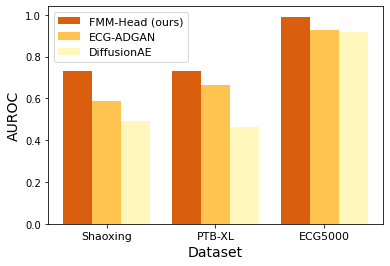

In [10]:
def get_best_auroc_from_models(df, model_names_list):
    best_result_df_ids = df[df["Model"].isin(model_names_list)].groupby(["Dataset"])["Auroc"].idxmax()
    best_result_df = df.loc[best_result_df_ids]
    best_result_df = best_result_df.sort_values(by="Dataset",ascending=False)
    best_np = best_result_df["Auroc"].to_numpy()
    return best_np

best_fmm = get_best_auroc_from_models(df,fmm_model_names)
best_gan = get_best_auroc_from_models(df,gan_names)
best_diffusion = get_best_auroc_from_models(df,diffusion_names)
baseline_comparison_matrix = np.stack((best_fmm,best_gan,best_diffusion)) #np.concatenate([np.transpose(best_fmm),np.transpose(best_gan),np.transpose(best_diffusion)],axis=1)
plot_group_bars(["Shaoxing","PTB-XL","ECG5000"], baseline_comparison_matrix, ["FMM-Head (ours)","ECG-ADGAN","DiffusionAE"], 
                colors=[colors[1],colors[0],colors[2]], xlabel='Dataset', ylabel='AUROC',
                legend_fontsize=11, tick_fontsize=11,axis_fontsize=14)
save_png_eps_figure(f"non_ae_baseline_comparison")

shaoxing_fmm


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ptb_xl_fmm


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ecg5000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


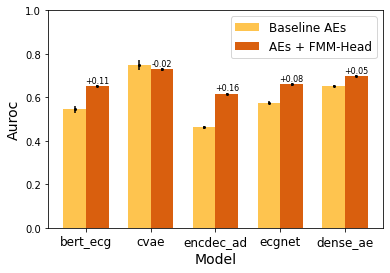

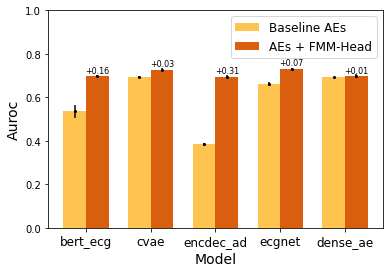

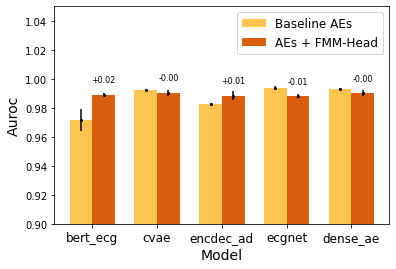

In [11]:
def plot_group_bar_with_std_and_arrow(groups, averages1, stds1, averages2, stds2,
                                      xlabel, ylabel, arrow_label=None, average3=None, 
                                      group3=None, y_log_scale=True,
                                      bar_text=None, bar_text_offset=None):
    bar_width = 0.35
    index = np.arange(len(groups))

    fig, ax = plt.subplots()
    if(y_log_scale):
        ax.set_yscale("log") 
    bars1 = ax.bar(index, averages1, bar_width, label='Baseline AEs', color=colors[0])
    if(stds1 is not None):
        errbars1 = ax.errorbar(index, averages1, yerr=stds1, fmt="o", color="black", markersize=2)
    bars2 = ax.bar(index + bar_width, averages2, bar_width, label='AEs + FMM-Head', color=colors[1])
    if(stds2 is not None):
        errbars2 = ax.errorbar(index + bar_width, averages2, yerr=stds2, fmt="o", color="black", markersize=2)
    if(average3 is not None):
        bars3 = ax.bar(len(groups)+ bar_width/2, average3, bar_width, label=group3, color=colors[2])
    # Adding text boxes on top of each bar of averages2
    for i,(bar2,tx) in enumerate(zip(bars2,bar_text)):
        if(y_log_scale==True):
            texty = np.log10(bar2.get_height()+0.31) + 0.5
        else:
            texty = bar2.get_height()+bar_text_offset
        ax.text(bar2.get_x() + bar2.get_width()/2, texty,
                tx, fontsize=8, ha='center', va='bottom')
    if(average3 is not None):
        # Adding vertical arrow between Group 5 and Group 4 with label on the left of the arrow
        last_group_height = bars2[-1].get_height()
        group3height = bars3[0].get_height()
        
        ax.annotate(
            "",
            xy=(len(groups) - 0.5 + bar_width / 2, group3height),
            xytext=(len(groups) - 0.5 + bar_width / 2, last_group_height),
            arrowprops=dict(facecolor='green', arrowstyle='<->', linewidth=2),
            fontsize=12,
            ha='center',
            va='center'
        )
        ax.text(len(groups) - 1.5 + bar_width, np.log10((group3height+last_group_height)/2),
        arrow_label, fontsize=12, verticalalignment='center', bbox=dict(facecolor='white', edgecolor='white'))
    ax.set_xlabel(xlabel,size=labelssize)
    ax.set_ylabel(ylabel,size=labelssize)
    if(average3 is not None):
        index = np.arange(len(groups)+1)
        ax.set_xticks(index + bar_width / 2)
        ax.set_xticklabels(groups+["FMM-Model"])
    else:
        ax.set_xticks(ticks=index + bar_width / 2, labels=groups, size=ticksize)
        # ax.set_xticklabels(groups, size=ticksize)
    ax.legend(fontsize=legendsize)

def get_auroc_avg_std(df, md_name, ds_name):
    avg = df[(df['Model'] == md_name) & (df['Dataset'] == ds_name)]["Auroc"].to_numpy()[0]
    std = df[(df['Model'] == md_name) & (df['Dataset'] == ds_name)]["Auroc Std"].to_numpy()[0]
    return avg,std

groups = not_fmm_model_names
for ds_name in dataset_names:
    averages1, stds1 = zip(*[get_auroc_avg_std(best_result_df,nm,ds_name) for nm in not_fmm_model_names])
    averages2, stds2 = zip(*[get_auroc_avg_std(best_result_df,nm,ds_name) for nm in fmm_model_names])
    gain_to_baseline = [format_number_with_sign(100*(av2-av1)/av1)+"%" for av1,av2 in zip(averages1,averages2)]
    gain_to_baseline = [format_number_with_sign(av2-av1,decimals=2) for av1,av2 in zip(averages1,averages2)]
    print(ds_name)
    if(ds_name!="ecg5000"):
        plot_group_bar_with_std_and_arrow(groups=groups, averages1=averages1, stds1=stds1, averages2=averages2, stds2=stds2,
                                            xlabel='Model', ylabel='Auroc', y_log_scale=False, bar_text=gain_to_baseline,
                                            bar_text_offset=0.005)
        plt.ylim([0,1])
    elif(ds_name=="ecg5000"):
        plot_group_bar_with_std_and_arrow(groups=groups, averages1=averages1, stds1=stds1, averages2=averages2, stds2=stds2,
                                            xlabel='Model', ylabel='Auroc', y_log_scale=False, bar_text=gain_to_baseline,
                                            bar_text_offset=0.007)
        plt.ylim([0.9,1.05])
    save_png_eps_figure(f"auroc_{ds_name}")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


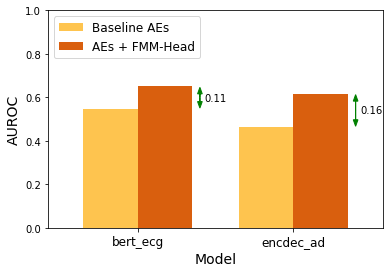

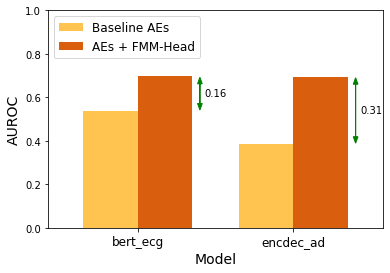

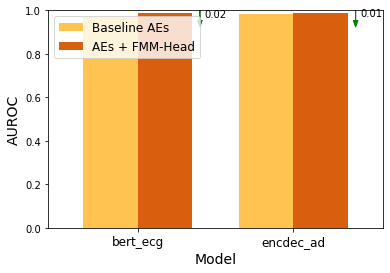

In [12]:
def plot_grouped_bar_with_arrows(values_group1, values_group2, x_labels, y_label, x_label, title, groups_names):
    fig, ax = plt.subplots()
    bar_width = 0.35
    index = np.arange(len(values_group1))
    bar1 = ax.bar(index, values_group1, bar_width, color=colors[0], label=groups_names[0])
    index2 = index + bar_width
    bar2 = ax.bar(index2, values_group2, bar_width, color=colors[1], label=groups_names[1])
    # Add arrows and text boxes
    for i in range(len(values_group1)):
        diff = values_group2[i] - values_group1[i]
        plt.arrow(index2[i] + bar_width/2 + 0.05, values_group1[i] + diff/2, 0, -diff/2 + 0.035, head_width=0.03, head_length=0.03, fc='green', ec='green')
        plt.arrow(index2[i] + bar_width/2 + 0.05, values_group1[i] + diff/2, 0, diff/2 - 0.035, head_width=0.03, head_length=0.03, fc='green', ec='green')
        ax.text(index2[i] + bar_width/2 + 0.15, (values_group1[i] + values_group2[i]) / 2, f'{diff:.2f}', ha='center', va='center')
    ax.set_xlabel(x_label, size=labelssize)
    ax.set_ylabel(y_label, size=labelssize)
    ax.set_title(title, size=labelssize)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(x_labels, size=ticksize)
    plt.xlim([index[0]-bar_width-0.05,index2[-1]+bar_width+0.05])
    ax.legend(fontsize=legendsize, loc='upper left')

for ds_name in dataset_names:
    averages1, stds1 = zip(*[get_auroc_avg_std(best_result_df,nm,ds_name) for nm in ["bert_ecg","encdec_ad"]])
    averages2, stds2 = zip(*[get_auroc_avg_std(best_result_df,nm,ds_name) for nm in ["fmm_bert_ecg","fmm_encdec_ad"]])
    x_labels = ['bert_ecg', 'encdec_ad']
    y_label = 'AUROC'
    x_label = 'Model'
    title = ''
    plot_grouped_bar_with_arrows(values_group1=averages1, values_group2=averages2, 
                                x_labels=x_labels, y_label=y_label, x_label=x_label, 
                                title=title, groups_names=['Baseline AEs', 'AEs + FMM-Head'])
    plt.ylim([0,1])
    save_png_eps_figure(f"auroc_improvement_{ds_name}")


In [13]:
plot_realizations = False
if(plot_realizations):
    data_path = "/mnt/giacomo/sfl/data"
    dataset_names = ["shaoxing_fmm", "ptb_xl_fmm","ecg5000"]
    dataset_load_functions = {"ptb_xl_fmm": lambda: get_ptb_xl_fmm_dataset(datapath=data_path, sequence_length=300, num_waves=5, lead=1, num_leads=1),
                            "shaoxing_fmm": lambda: get_shaoxing_fmm_dataset(datapath=data_path, sequence_length=300, num_waves=5, lead=1, num_leads=1),
                            "ecg5000": lambda: get_ecg5000_dataset(datapath=data_path)}
    def plot_variable_realizations(variables, values, title=None, xlabel=None, ylabel=None, fontsize=12, markersize=5):
        # Check if the number of variables matches the number of columns in the values array
        if len(variables) != values.shape[1]:
            raise ValueError("The number of variables must match the number of columns in the values array.")
        
        # Create a figure and axis
        fig, ax = plt.subplots()

        # Calculate the x-coordinates with spacing
        num_variables = len(variables)
        x_coords = np.arange(num_variables)

        # Plotting red dots for each value with adjusted x-coordinates
        x_list = []
        for i in range(num_variables):
            variable_name = variables[i]
            variable_values = values[:, i]
            x_adjusted = x_coords[i] + (i // 4) * 0.5  # Add a small gap every 4 variables
            x_list.append(x_adjusted)
            ax.plot([x_adjusted] * len(variable_values), variable_values, 'ro', alpha=0.004, markersize=markersize)

        # Adding labels and title
        if xlabel:
            ax.set_xlabel(xlabel, fontsize=fontsize)
        if ylabel:
            ax.set_ylabel(ylabel, fontsize=fontsize)
        if title:
            ax.set_title(title, fontsize=fontsize)

        # Set x-axis ticks at the middle of each group of 4 variables
        # x_ticks = np.arange(0.25, num_variables, 4.5)
        ax.set_xticks(x_list)
        ax.set_xticklabels(variables, rotation=90, fontsize=fontsize, ha='center')
        
    dataset_stats_list=[]
    for ds_name in  ["ecg5000","shaoxing_fmm","ptb_xl_fmm"]:#["shaoxing_fmm", "ptb_xl_fmm","ecg5000"]:
        raw_dataset_dict = dataset_load_functions[ds_name]()
        data = raw_dataset_dict["train"]["data"] 
        labels = raw_dataset_dict["train"]["labels"] 
        test_data = raw_dataset_dict["test"]["data"] 
        test_labels = raw_dataset_dict["test"]["labels"] 
        normal_class = raw_dataset_dict["params"]["normal_class"]
        leg = raw_dataset_dict["params"]["classes"]
        class_count = {class_name: np.sum(labels==i)+np.sum(test_labels==i) for i,class_name in enumerate(leg)}
        dict_to_add = {"Dataset": ds_name, 
                    "Num samples":len(labels)+len(test_labels), 
                    "Normal samples": int(np.sum(labels==normal_class)+np.sum(test_labels==normal_class)), 
                    "Abnormal samples": int(np.sum(labels!=normal_class)+np.sum(test_labels!=normal_class)),
                    }
        dataset_stats_list.append(dict_to_add)
        if(ds_name in ["shaoxing_fmm","ptb_xl_fmm"]):
            coefficients_names = get_parameters_names_list(num_features,num_waves)
            values = raw_dataset_dict["train"]["coefficients"]
            plot_variable_realizations(coefficients_names, values, title="", xlabel="Coefficient Name", ylabel="Coefficient Value", fontsize=14, markersize=3)
            save_png_eps_figure(f"coefficients_distribution_{ds_name}")
    df = pd.DataFrame(dataset_stats_list)
    df.head()  
    coefficients_names = get_parameters_names_list(1,5)
    values = raw_dataset_dict["train"]["coefficients"]
    plot_variable_realizations(coefficients_names, values, title="", xlabel="Coefficient Name", ylabel="Coefficient Value", fontsize=14, markersize=3)

In [14]:
# Define model names
current_path = os.getcwd()
results_path = os.path.join(current_path,"results")
model_names = ["fmm_bert_ecg", "bert_ecg","fmm_encdec_ad","encdec_ad", 
               "fmm_ecgnet","ecgnet", "fmm_dense_ae", "dense_ae", "fmm_cae", "cvae"]
# Define dataset names
dataset_names = ["ptb_xl_fmm", "ecg5000", "shaoxing_fmm"]
# Define all learning rates
learning_rate_values = [1e-4] #[8e-4]
learning_rate_values_str = ["{:.0e}".format(lr) for lr in learning_rate_values]
history_dict_list = []
for ds_name in dataset_names:
    ds_history_dict = {}
    for md_name in model_names:
        history_key = history_key_dict[md_name]
        metric_name = key_to_metric[history_key]
        md_history_dict = {}
        for lr in learning_rate_values:
            lr_dict = {}
            exp_paths = get_all_experiments_paths(base_path=results_path,
                                                  model=md_name,
                                                  dataset=ds_name,
                                                  learning_rate=lr,
                                                  split=True, 
                                                  optimizer="Adam",)
            conf_files = get_conf_from_paths(exp_paths)
            completed_config_files = get_completed_paths(config_files=conf_files,log=False)
            completed_paths = [cfg["path"] for cfg in completed_config_files]
            # Part to add
            completed_model_size = load_binary_dict_from_paths(completed_paths, "model_size")
            completed_model_size = [mydict["model_size_mb"] for mydict in completed_model_size]
            completed_model_size_avg = np.average(completed_model_size)
            # inference_times = load_numpy_from_paths(completed_paths, "inference_times.npy")
            inference_times = [x["avg_predict_time"] for x in load_binary_dict_from_paths(completed_paths, "predict_time")]
            inference_times_avg = np.average(inference_times)
            inference_times_std = np.std(inference_times)
            train_times = [x["train_time"] for x in load_binary_dict_from_paths(completed_paths, "train_time")]
            train_times_avg = np.average(train_times)
            train_times_std = np.std(train_times)
            warmup_times = [x["warmup_time"] for x in load_binary_dict_from_paths(completed_paths, "train_time")]
            warmup_times_avg = np.average(warmup_times)
            warmup_times_std = np.std(warmup_times)
            train_epoch_times = [x["train_epochs_time"] for x in load_binary_dict_from_paths(completed_paths, "train_time")]
            train_epoch_times_avg = np.average(train_epoch_times)
            train_epoch_times_std = np.std(train_epoch_times)
            warmup_epoch_times = [x["warmup_epochs_time"] for x in load_binary_dict_from_paths(completed_paths, "train_time")]
            warmup_epoch_times_avg = np.average(warmup_epoch_times)
            warmup_epoch_times_std = np.std(warmup_epoch_times)
            #####
            # np.testing.assert_allclose(completed_model_size,completed_model_size[0]*np.ones_like(completed_model_size))
            completed_histories = load_binary_dict_from_paths(completed_paths, "history.json")
            completed_rocs = load_json_from_exp(completed_paths,file_name="test_roc.json")
            history_matrix = extract_key_from_histories(completed_histories,key=history_key)
            
            roc_vector = extract_auroc_from_roc_list(completed_rocs)
            lr_dict[history_key] = history_matrix 
            lr_dict["auroc"] = roc_vector 
            num_experiments = history_matrix.shape[0]
            assert roc_vector.shape[0]==num_experiments
            
            dict_to_add = {"Dataset": ds_name, "Model": md_name, "Learning Rate":lr,
                                        "Auroc": np.mean(roc_vector), 
                                        "Auroc Std": np.std(roc_vector),
                                        "Num Exp": num_experiments,
                                        # Part to add
                                        "Model size": completed_model_size_avg,
                                        "Inference time Avg":inference_times_avg,
                                        "Inference time Std":inference_times_std,
                                        "Inference times":inference_times,
                                        "Train time Avg":train_times_avg,
                                        "Train time Std":train_times_std,
                                        "Train times":train_times,
                                        "Warmup time Avg":warmup_times_avg,
                                        "Warmup time Std":warmup_times_std,
                                        "Warmup times":warmup_times,
                                        "Train epoch time Avg":train_epoch_times_avg,
                                        "Train epoch time Std":train_epoch_times_std,
                                        "Train epoch times":train_epoch_times,
                                        "Warmup epoch time Avg":warmup_epoch_times_avg,
                                        "Warmup epoch time Std":warmup_epoch_times_std,
                                        "Warmup epoch times":warmup_epoch_times,              
                                        }
            #####
            if(md_name in fmm_model_names and ds_name!="ecg5000"):
                completed_corrs = load_json_from_exp(completed_paths, file_name="correlation_normal_sorted")
                assert len(completed_corrs)==num_experiments
                avg_corrs, std_corrs = calculate_avg_std_from_dictionaries(completed_corrs)
                lr_dict["correlation_sorted"] = completed_corrs 
                dict_to_add["Correlation"] = avg_corrs
                dict_to_add["Correlation Std"] = std_corrs
            history_dict_list.append(dict_to_add)

/home/giacomo/installers/anaconda3/envs/sfl31/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/giacomo/installers/anaconda3/envs/sfl31/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/giacomo/installers/anaconda3/envs/sfl31/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/giacomo/installers/anaconda3/envs/sfl31/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/giacomo/installers/anaconda3/envs/sfl31/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type

In [15]:
def plot_group_bar_with_std(groups, averages1, stds1, averages2, stds2, 
                            xlabel, ylabel, average3=None, group3=None, y_log_scale=True,
                            bar_text=None, text_x_offset=0.0):
    bar_width = 0.35
    index = np.arange(len(groups))

    fig, ax = plt.subplots()
    bars1 = ax.barh(index, averages1, bar_width, label='Baseline AEs', color=colors[0])
    if(stds1 is not None):
        errbars1 = ax.errorbar(averages1,index, xerr=stds1, fmt="o", color="black", markersize=2)
    bars2 = ax.barh(index + bar_width, averages2, bar_width, label='AEs + FMM-Head', color=colors[1])
    if(stds2 is not None):
        errbars2 = ax.errorbar(averages2, index + bar_width, xerr=stds2, fmt="o", color="black", markersize=2)
    if(average3 is not None):
        bars3 = ax.barh(average3, len(groups)+ bar_width/2, bar_width, label=group3, color=colors[2])
    # Adding text boxes on top of each bar of averages2
    ax.invert_yaxis()
    if(bar_text is not None):
        for i,(bar2,tx) in enumerate(zip(bars2,bar_text)):
            # ax.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.5,
            #         tx, fontsize=8, ha='center', va='bottom')
            ax.text(bar2.get_width() + text_x_offset, bar2.get_y() + bar_width/2 + 0.1,
                    tx, fontsize=11, ha='center', va='bottom')
    if(y_log_scale):
        ax.set_xscale("log")
    ax.set_ylabel(xlabel, size=labelssize)
    ax.set_xlabel(ylabel, size=labelssize)
    # ax.set_title('Group Bar Plot with Averages and Std')
    
    if(average3 is not None):
        index = np.arange(len(groups)+1)
        ax.set_yticks(index + bar_width / 2)
        ax.set_yticklabels(groups+["FMM-Model"], size=ticksize)
    else:
        ax.set_yticks(index + bar_width / 2)
        ax.set_yticklabels(groups, size=ticksize)
    plt.yticks(rotation=0)
    ax.legend(fontsize=legendsize)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


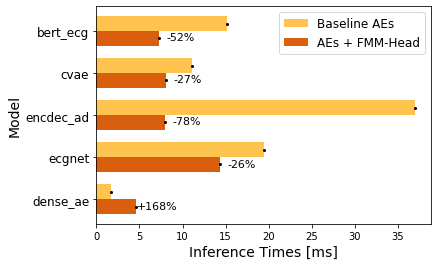

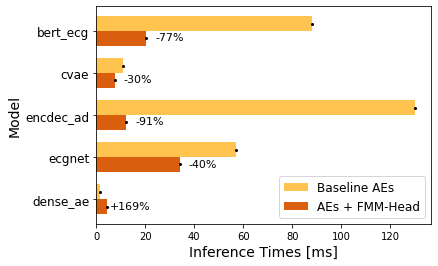

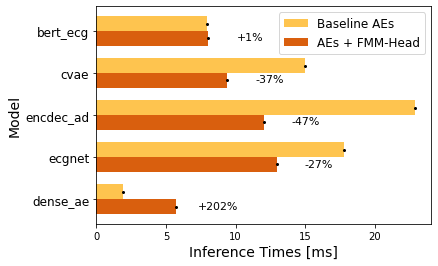

In [16]:
df=pd.DataFrame(history_dict_list)
groups = not_fmm_model_names
def get_inf_time_avg_std(md_name, ds_name):
    avg = df[(df['Model'] == md_name) & (df['Dataset'] == ds_name)]["Inference time Avg"].to_numpy()[0]
    std = df[(df['Model'] == md_name) & (df['Dataset'] == ds_name)]["Inference time Std"].to_numpy()[0]
    return avg,std
# [get_inf_time_avg_std(nm) for nm in not_fmm_model_names]
for ds_name,text_x_offset in zip(["ptb_xl_fmm","shaoxing_fmm","ecg5000"],[2.5,9.5,3]):
    averages1, stds1 = zip(*[get_inf_time_avg_std(nm,ds_name) for nm in not_fmm_model_names])
    averages2, stds2 = zip(*[get_inf_time_avg_std(nm,ds_name) for nm in fmm_model_names])

    fmm_opt_times = np.load(os.path.join("/","home","giacomo","ScalableFederatedLearning","data","ptb_xl_fmm","test","elapsed_times.npy"))
    average_fmm_times = np.average(fmm_opt_times)
    gain_to_fmm = average_fmm_times/np.average(averages2)
    from src.utils.general_functions import format_number_with_sign
    gain_to_baseline = [format_number_with_sign(100*(av2-av1)/av1)+"%" for av1,av2 in zip(averages1,averages2)]
    fmm_arrow_label = "x {:.0f}".format(gain_to_fmm)
    # plot_group_bar_with_std_and_arrow(groups=groups, averages1=averages1, stds1=stds1, averages2=averages2, stds2=stds2,
    #                                       xlabel='Model', ylabel='Inference Times [s]', arrow_label=fmm_arrow_label, average3=average_fmm_times, 
    #                                       group3="FMM-Optimization", y_log_scale=True,
    #                                       bar_text=gain_to_baseline)
    # plot_group_bar_with_std_and_arrow(groups=groups, averages1=[1000*x for x in averages1], stds1=stds1, averages2=[1000*x for x in averages2], stds2=stds2,
    #                                     xlabel='Model', ylabel='Inference Times [ms]', y_log_scale=False, bar_text=gain_to_baseline,
    #                                     bar_text_offset=0.5)
    plot_group_bar_with_std(groups, [1000*x for x in averages1], stds1, [1000*x for x in averages2], stds2, 
                            'Model', 'Inference Times [ms]', None, None, False,gain_to_baseline,text_x_offset=text_x_offset)
    save_png_eps_figure(f"inference_times_{ds_name}")


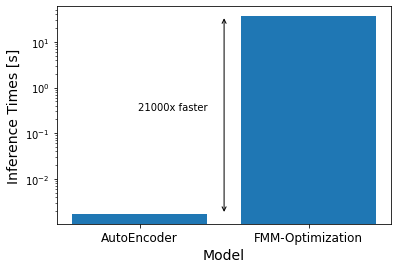

In [17]:
def plot_with_arrow(y1, x2, xlabel, ylabel, title, tick_labels=('Model A', 'Model B')):
    ratio = y2 / y1
    fig, ax = plt.subplots()
    ax.bar([1, 2], [y1, y2], log=True)
    ax.set_xticks([1, 2])
    ax.set_xticklabels(tick_labels, size=ticksize)
    # ax.set_yticks([0, 0.01, 0.1, 1, 10])
    # ax.set_yticklabels([0, 0.01, 0.1, 1, 10])
    # ax.set_ylim([0,100])
    ax.annotate('', xy=(1.5, y1), xytext=(1.5, y2),
                arrowprops=dict(arrowstyle='<->'))
    ax.text(1.4, (y1 + y2) / 100, f'{round(ratio/10000,1)*10000:.0f}x faster',
            ha='right', va='center')
    ax.set_xlabel(xlabel, size=labelssize)
    ax.set_ylabel(ylabel, size=labelssize)
    ax.set_title(title, size=labelssize)

for ds_name in ["ptb_xl_fmm"]:
    y1 = get_inf_time_avg_std("dense_ae",ds_name)[0] # Get only average
    fmm_opt_times = np.load(os.path.join("/","home","giacomo","ScalableFederatedLearning","data","ptb_xl_fmm","test","elapsed_times.npy"))
    y2 = np.average(fmm_opt_times)
    xlabel = 'Model'
    ylabel = 'Inference Times [s]'
    title = ""
    tick_labels = ("AutoEncoder", "FMM-Optimization")
    plot_with_arrow(y1, y2, xlabel, ylabel, title, tick_labels)
    save_png_eps_figure(f"inference_times_ae_to_fmm_{ds_name}")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


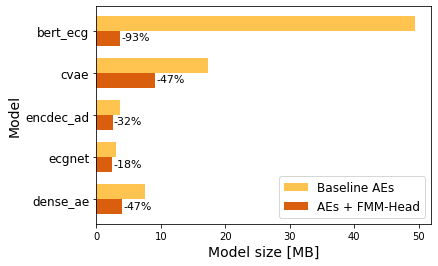

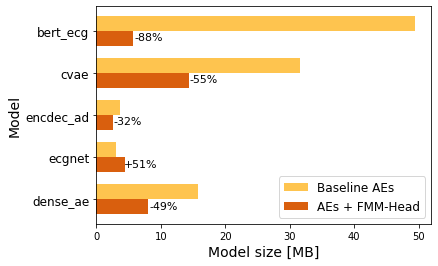

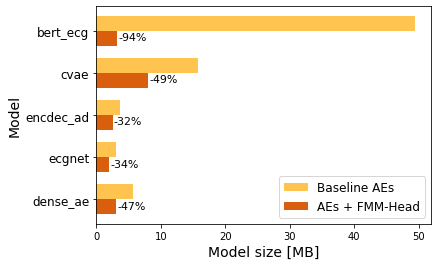

In [18]:
groups = not_fmm_model_names
def get_model_size(md_name,ds_name):
    avg = df[(df['Model'] == md_name) & (df['Dataset'] == ds_name)]["Model size"].to_numpy()[0]
    # std = df[df['Model'] == md_name]["Inference time Std"].to_numpy()[0]
    return avg
for ds_name in ["ptb_xl_fmm","shaoxing_fmm","ecg5000"]:
    averages1 = [get_model_size(nm,ds_name) for nm in not_fmm_model_names]
    averages2 = [get_model_size(nm,ds_name) for nm in fmm_model_names]
    gain_to_baseline = [format_number_with_sign(100*(av2-av1)/av1)+"%" for av1,av2 in zip(averages1,averages2)]
    plot_group_bar_with_std(groups, averages1, None, averages2, None, 'Model', 'Model size [MB]', None, None, False,gain_to_baseline,text_x_offset=2.4)
    save_png_eps_figure(f"model_size_{ds_name}")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


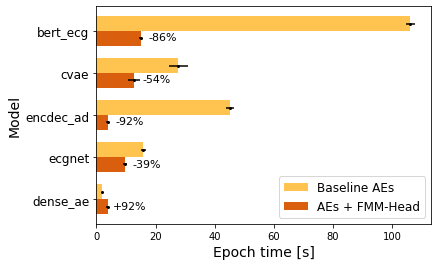

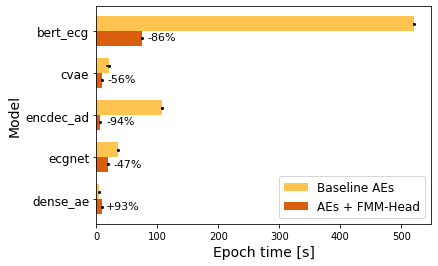

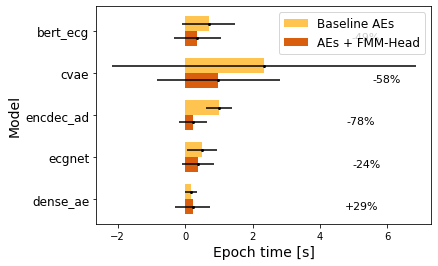

In [19]:
groups = not_fmm_model_names
def get_train_epochs_time(md_name):
    avg = df[(df['Model'] == md_name) & (df['Dataset'] == ds_name)]["Train epoch time Avg"].to_numpy()[0]
    std = df[(df['Model'] == md_name) & (df['Dataset'] == ds_name)]["Train epoch time Std"].to_numpy()[0]
    return avg,std
for ds_name,text_x_offset in zip(["ptb_xl_fmm","shaoxing_fmm","ecg5000"],[7.5,33,5]):
    averages1,std1 = zip(*[get_train_epochs_time(nm) for nm in not_fmm_model_names])
    averages2, std2 = zip(*[get_train_epochs_time(nm) for nm in fmm_model_names])
    gain_to_baseline = [format_number_with_sign(100*(av2-av1)/av1)+"%" for av1,av2 in zip(averages1,averages2)]
    plot_group_bar_with_std(groups, averages1, std1, averages2, std2, 'Model', 'Epoch time [s]', None, None, False,gain_to_baseline,text_x_offset=text_x_offset)
    save_png_eps_figure(f"train_epochs_times_{ds_name}")

In [20]:
df["Total train time"] = df["Train time Avg"] + df["Warmup time Avg"]
# Pivot the table to achieve the desired format
pivot_table = df.pivot_table(index="Model", columns="Dataset", values=["Total train time"],aggfunc=lambda x: round(x/60,1))

# Reorder the rows based on model_names
pivot_table = pivot_table.reindex(model_names)
pivot_table = pivot_table.reindex(columns=[('Total train time',x)for x in ["shaoxing_fmm", "ptb_xl_fmm", "ecg5000"]])
# pivot_table = pivot_table[[("Auroc",str(ds)) for ds in dataset_names]]
pivot_table

Total train time                   
Dataset           shaoxing_fmm ptb_xl_fmm ecg5000
Model                                            
fmm_bert_ecg             218.0       94.3     1.7
bert_ecg                 147.6       33.6     1.0
fmm_encdec_ad             59.9       29.8     1.9
encdec_ad                 28.5       12.8     2.2
fmm_ecgnet               156.3       70.2     3.3
ecgnet                    81.3       29.3     4.3
fmm_dense_ae              48.3       12.0     0.8
dense_ae                  15.3        6.4     1.2
fmm_cae                   24.9       34.3     2.6
cvae                     103.2      101.6     8.4